In [17]:
!pip install avalanche-lib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [18]:
"""
This is a simple example on how to use the Replay strategy.
"""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import matplotlib.pyplot as plt
import numpy as np
import argparse
import torch
from torch.nn import CrossEntropyLoss
from torchvision import transforms
from torchvision.transforms import ToTensor, RandomCrop
import torch.optim.lr_scheduler
from avalanche.benchmarks import SplitMNIST
from avalanche.models import MlpVAE, SimpleMLP
from avalanche.training.supervised import GenerativeReplay, VAETraining
from avalanche.evaluation.metrics import (
    forgetting_metrics,
    accuracy_metrics,
    loss_metrics,
)
from avalanche.logging import InteractiveLogger
from avalanche.training.plugins import EvaluationPlugin, GenerativeReplayPlugin

In [19]:
device = torch.device(
    f"cuda:{args.cuda}"
    if torch.cuda.is_available()
    else "cpu"
)

# --- SCENARIO CREATION
scenario = SplitMNIST(n_experiences=10, seed=1234)
# ---------

# MODEL CREATION
model_replay = SimpleMLP(num_classes=scenario.n_classes)
model_vae = MlpVAE((1, 28, 28), nhid=2, device=device)

# choose some metrics and evaluation method
interactive_logger = InteractiveLogger()

eval_plugin = EvaluationPlugin(
    accuracy_metrics(
        minibatch=True, epoch=True, experience=True, stream=True
    ),
    loss_metrics(minibatch=True, epoch=True, experience=True, stream=True),
    forgetting_metrics(experience=True),
    loggers=[interactive_logger],
)

# CREATE THE STRATEGY INSTANCE (GenerativeReplay)
cl_strategy_replay = GenerativeReplay(
    model_replay,
    torch.optim.Adam(model_replay.parameters(), lr=0.001),
    CrossEntropyLoss(),
    train_mb_size=100,
    train_epochs=4,
    eval_mb_size=100,
    device=device,
    evaluator=eval_plugin,
)

cl_strategy_vae = VAETraining(
    model_vae,
    torch.optim.Adam(model_vae.parameters(), lr=0.001),
    train_mb_size=100,
    train_epochs=4,
    device=device,
    plugins=[GenerativeReplayPlugin()],
)

/usr/local/lib/python3.7/dist-packages/avalanche/training/plugins/evaluation.py:82: UserWarning: No benchmark provided to the evaluation plugin. Metrics may be computed on inconsistent portion of streams, use at your own risk.
  "No benchmark provided to the evaluation plugin. "


Starting experiment...
Start of experience  0
-- >> Start of training phase << --
100%|██████████| 55/55 [00:02<00:00, 24.40it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0614
	Loss_MB/train_phase/train_stream/Task000 = 0.0000
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9817
	Top1_Acc_MB/train_phase/train_stream/Task000 = 1.0000
100%|██████████| 55/55 [00:02<00:00, 22.95it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0000
	Loss_MB/train_phase/train_stream/Task000 = 0.0000
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
	Top1_Acc_MB/train_phase/train_stream/Task000 = 1.0000
100%|██████████| 55/55 [00:02<00:00, 19.56it/s]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0000
	Loss_MB/train_phase/train_stream/Task000 = 0.0000
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
	Top1_Acc_MB/train_phase/train_stream/Task000 = 1.0000
100%|██████████| 55/55 [00:04<00:00, 13.67it/s]
Epoch 3 ended.
	Loss_Epoch/

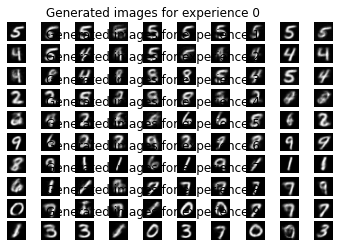

In [20]:
# TRAINING LOOP
print("Starting experiment...")
f, axarr = plt.subplots(scenario.n_experiences, 10)
k = 0
results = []
for experience in scenario.train_stream:
    print("Start of experience ", experience.current_experience)
    cl_strategy_replay.train(experience) # training replay model
    cl_strategy_vae.train(experience) # training vae model
    print("Training completed")

    print("Computing accuracy on the whole test set")
    results.append(cl_strategy_replay.eval(scenario.test_stream))

    # generate samples from the vae model
    samples = model_vae.generate(10)
    samples = samples.detach().cpu().numpy()

    for j in range(10):
        axarr[k, j].imshow(samples[j, 0], cmap="gray")
        axarr[k, 4].set_title("Generated images for experience " + str(k))
    np.vectorize(lambda ax: ax.axis("off"))(axarr)
    k += 1

In [21]:
f.subplots_adjust(hspace=1.2)
plt.savefig("VAE_output_per_exp")
plt.show()

<Figure size 432x288 with 0 Axes>